## Original Description
> Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.
>
> The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.
>
> While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!
>
> To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.
>
> Help save them and change history!

### Features
- `PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.
- `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- `Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- `Destination` - The planet the passenger will be debarking to.
- `Age` - The age of the passenger.
- `VIP` - Whether the passenger has paid for special VIP service during the voyage.
- `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- `Name` - The first and last names of the passenger.

### Labels
- `Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [40]:
# !pip3 install -r requirements.txt

In [41]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import eli5
from eli5.sklearn import PermutationImportance
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import cross_val_score, HalvingGridSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

warnings.filterwarnings('ignore')

In [42]:
%matplotlib inline

In [43]:
redo_graphs = 0

In [44]:
try:
    df = pd.read_csv('data_FAA/train.csv')
    # df_test = pd.read_csv('../input/spaceship-titanic/test.csv')
except FileNotFoundError:
    df = pd.read_csv('data_FAA/train.csv')
    # df_test = pd.read_csv('/spaceship-titanic/test.csv')
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [45]:
def preprocess(df, preTrain = True):
    # drop the entire cols that have low to now interest for now
    if preTrain:
        df = df.dropna()

    df['PassengerId_split'] = df['PassengerId'].apply(lambda x : str(x).split(sep = '_', maxsplit=1))
    df['Group']= df['PassengerId_split'].apply(lambda x : np.nan if x[0] == 'nan' else x[0])
    df['Group_id']= df['PassengerId_split'].apply(lambda x : np.nan if x[0] == 'nan' else x[1])
    df = df.drop(['PassengerId','PassengerId_split'],axis=1)

    df['Name_split'] = df['Name'].apply(lambda x : str(x).split(sep = ' ', maxsplit=1))
    df['FirstName']= df['Name_split'].apply(lambda x : np.nan if x[0] == 'nan' else x[0])
    df['Surname']= df['Name_split'].apply(lambda x : np.nan if x[0] == 'nan' else x[1])
    df = df.drop(['Name','Name_split'],axis=1)

    # Split the cabins
    df['Cabin_splt'] = df['Cabin'].apply(lambda x : str(x).split(sep = '/'))

    df['Deck']= df['Cabin_splt'].apply(lambda x : np.nan if x[0] == 'nan' else x[0])
    df['CabinNumber']= df['Cabin_splt'].apply(lambda x : np.nan if x[0] == 'nan' else x[1]).astype('float')
    df['CabinSide']= df['Cabin_splt'].apply(lambda x : np.nan if x[0] == 'nan' else x[2])

    df = df.drop(['Cabin','Cabin_splt'],axis=1)

    numeric_cols = list(df.select_dtypes(include = np.number).columns)
    print(f"Numeric columns ({len(numeric_cols)}) :", ", ".join(numeric_cols))

    category_cols = list(df.select_dtypes(include = ['object']).columns)
    print(f"Categorical columns ({len(category_cols)}) :", ", ".join(category_cols))

    # processing categorical null value
    for col in category_cols:
    #         print(f"{col} mode : {all_data[col].mode()[0]}")
        df[col] = df[col].fillna(df[col].mode()[0])

    # processing numerical null value
    for col in numeric_cols:
        # using the mode
        df[col] = df[col].fillna(df[col].mode()[0])

    df_n=df[numeric_cols]
    df_c=df[category_cols]

    # label encode
    enc = LabelEncoder()
    for col in category_cols:  
        df_c[col] = enc.fit_transform(df_c[col])

    for col in ['HomePlanet', 'Destination', "Surname", "FirstName", "Group",]:
        df_c[f'{col}_count'] = df_c[col].map(df_c[col].value_counts())
        df_c[col] = df_c[col].replace(-1, np.nan)
    # print(f"Count columns ({len(category_cols)}) :", ", ".join(category_cols))

    for column in df_c:
        df_n[f"cat_{column}"] = df_c[column]

    df_n['Total'] = sum(df[col] for col in numeric_cols if col not in ["Age", "CabinNumber"])

    # Categorize the Total Spending 0.43
    df_n['SpendCategory'] = ''
    df_n.loc[df_n['Total'].between(0, 1, 'left'), 'SpendCategory'] = 'ZeroSpend'
    df_n.loc[df_n['Total'].between(1, 500, 'both'), 'SpendCategory'] = 'Under500'
    df_n.loc[df_n['Total'].between(500, 1000, 'right'), 'SpendCategory'] = 'Under1k'
    df_n.loc[df_n['Total'].between(1000, 1500, 'right'), 'SpendCategory'] = 'Under1.5k'
    df_n.loc[df_n['Total'].between(1500, 2000, 'right'), 'SpendCategory'] = 'Under2k'
    df_n.loc[df_n['Total'].between(2000, 2500, 'right'), 'SpendCategory'] = 'Under2.5k'
    df_n.loc[df_n['Total'].between(2500, 3000, 'right'), 'SpendCategory'] = 'Under3k'
    df_n.loc[df_n['Total'].between(3000, 999999, 'right'), 'SpendCategory'] = 'Above3k'
    df_n['SpendCategory'] = df_n['SpendCategory'].astype('category').cat.codes.astype("int") 

    # Dividing in intervals of 10 gave a correlation of -0.09 to Transported, diving into 4 categories gave a -0.12
    df_n['AgeCategory'] = ''
    df_n.loc[df_n['Age'].between(0, 18, 'both'), 'Age_Category'] = 'Under18'
    df_n.loc[df_n['Age'].between(18, 40, 'right'), 'Age_Category'] = 'Adult'
    df_n.loc[df_n['Age'].between(40, 60, 'right'), 'Age_Category'] = 'MiddleAge'
    df_n.loc[df_n['Age'].between(60, 100, 'right'), 'Age_Category'] = 'Over60'
    df_n['AgeCategory'] = df_n['Age_Category'].astype('category').cat.codes.astype("int")   

    df_n = df_n.drop(['Age', "Total"],axis=1)
    df_n["Transported"] = df["Transported"]
    return df_n

def split_x_y(df, preTrain = True):
    target = df['Transported']
    target = target.astype(int)
    return df, target

In [46]:
# initiate the traning and test datasets--for trainning
df_n = preprocess(df)
df_test, df_train = train_test_split(df_n, test_size = 0.2, random_state = 100)

Numeric columns (7) : Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck, CabinNumber
Categorical columns (10) : HomePlanet, CryoSleep, Destination, VIP, Group, Group_id, FirstName, Surname, Deck, CabinSide


In [47]:
df_test.head()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinNumber,cat_HomePlanet,cat_CryoSleep,cat_Destination,cat_VIP,...,cat_CabinSide,cat_HomePlanet_count,cat_Destination_count,cat_Surname_count,cat_FirstName_count,cat_Group_count,SpendCategory,AgeCategory,Age_Category,Transported
6669,0.0,0.0,0.0,0.0,0.0,1458.0,0,1,1,0,...,0,3566,623,4,6,2,7,1,MiddleAge,False
410,757.0,0.0,0.0,32.0,0.0,27.0,0,0,2,0,...,0,3566,4576,6,3,1,2,0,Adult,False
2523,0.0,0.0,0.0,0.0,0.0,523.0,2,0,2,0,...,1,1367,4576,2,1,2,7,3,Under18,True
3058,0.0,0.0,0.0,0.0,0.0,525.0,0,1,0,0,...,1,3566,1407,13,6,3,7,3,Under18,True
2453,0.0,0.0,0.0,0.0,0.0,545.0,2,1,0,0,...,0,1367,1407,4,1,1,7,1,MiddleAge,True


In [48]:
if redo_graphs:
    sns.pairplot(df_train, kind="scatter", hue="Transported")
    plt.show()
    plt.savefig("Imagens_FAA/Full_pairplot.png")

<img src="Imagens_FAA/Full_pairplot_original.png" style="width:1400px;height:1000px;">
<caption><center> **Fig. 1** : **Giant Scatter plot over all the Variables** </center></caption>

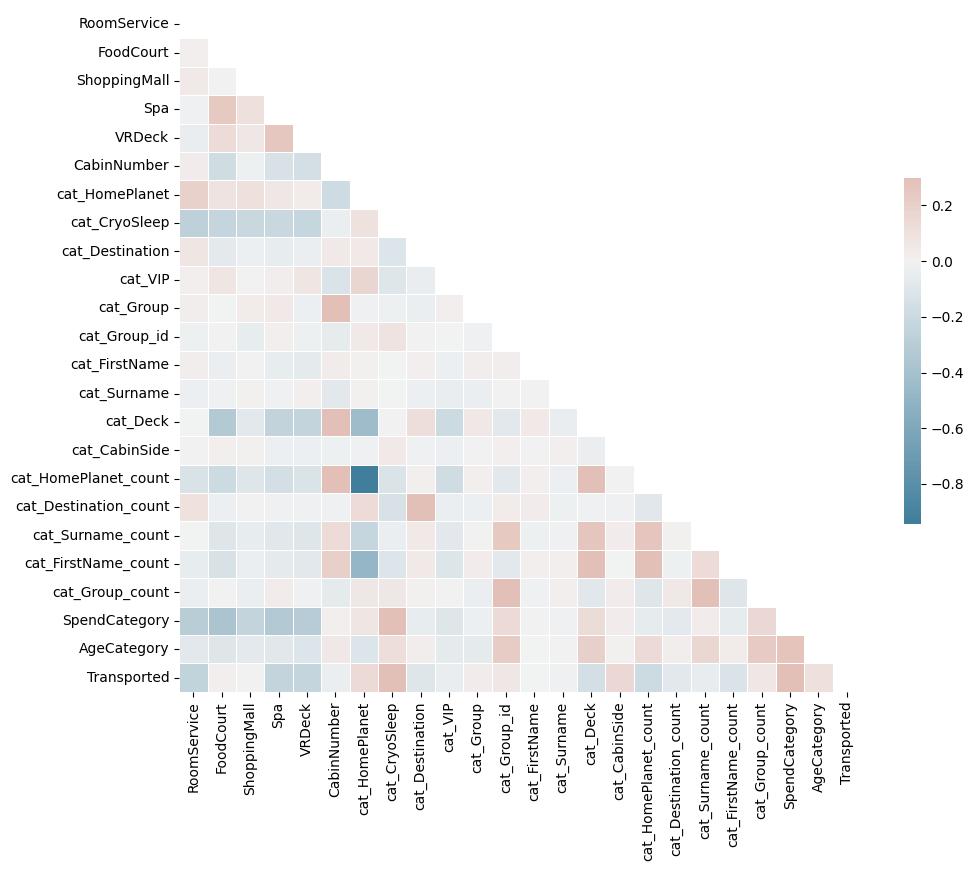

In [50]:
if redo_graphs:
    corr = df_train.corr()
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.4, cbar_kws={"shrink": .5})
    # Not sure of the reason why but the below command saves it some with border
    plt.savefig("Imagens_FAA/Correlation.png")

<img src="Imagens_FAA/Correlation.png" style="width:880px;height:720px;">
<caption><center> **Fig. 3** : **Corrleation plot** </center></caption>

In [56]:
corr["Transported"]

RoomService             -0.257087
FoodCourt                0.022580
ShoppingMall             0.005250
Spa                     -0.236505
VRDeck                  -0.233010
CabinNumber             -0.040163
cat_HomePlanet           0.142172
cat_CryoSleep            0.486919
cat_Destination         -0.103102
cat_VIP                 -0.041013
cat_Group                0.034379
cat_Group_id             0.062085
cat_FirstName           -0.006193
cat_Surname             -0.015609
cat_Deck                -0.147499
cat_CabinSide            0.150547
cat_HomePlanet_count    -0.197321
cat_Destination_count   -0.081703
cat_Surname_count       -0.050261
cat_FirstName_count     -0.124899
cat_Group_count          0.063470
SpendCategory            0.438257
AgeCategory              0.107965
Transported              1.000000
Name: Transported, dtype: float64

<AxesSubplot: xlabel='SpendCategory', ylabel='count'>

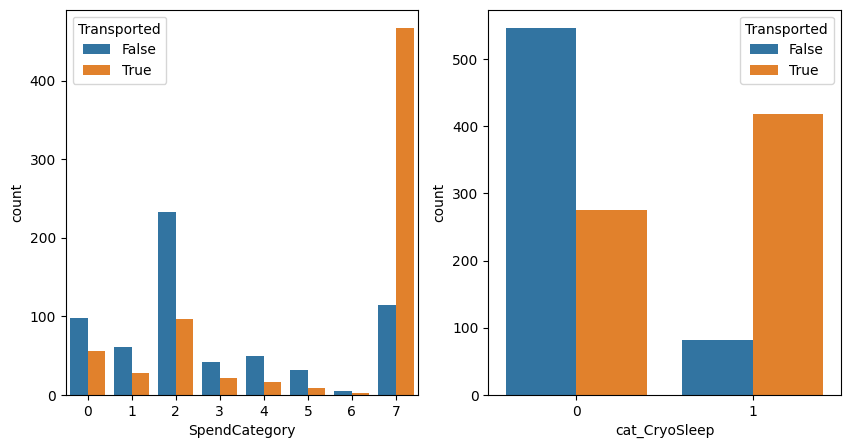

In [70]:
#define dimensions of subplots (rows, columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

#create chart in each subplot
sns.countplot(df_train, x="cat_CryoSleep", hue="Transported", ax=axes[1])
sns.countplot(df_train, x="SpendCategory", hue="Transported", ax=axes[0])

In [51]:
X_train, y_train = split_x_y(df_train)
X_test, y_test = split_x_y(df_test)

In [52]:
cols = X_train.columns[:-1]

In [53]:
PARAMETERS = {'normalize' : [True, False],
              'positive': [True, False],}

# HalvingGridSearchCV
grid_search_xgb = HalvingGridSearchCV(estimator=ElasticNet(objective="binary:logistic",
                                                           eval_metric="auc"),param_grid=PARAMETERS,verbose = 1,
                                                           cv = 10,scoring='accuracy',max_resources=1000,random_state = 0,
                                                           resource='n_samples',n_jobs=-1).fit(X_train.values, y_train.values.ravel())

xgbr_best = grid_search_xgb.best_estimator_
print("Elastic Net")
print('xgbr_best Best Score',grid_search_xgb.best_score_)
print('xgbr_best Best Parmas',grid_search_xgb.best_params_)
print('xgbr_best Accuracy',cross_val_score(xgbr_best,X_train.values, y_train.values.ravel(), cv=10).mean())
# print('xgbr feature importances',grid_search_xgb.feature_importances_)

TypeError: ElasticNet.__init__() got an unexpected keyword argument 'objective'

In [ ]:
PARAMETERS = {'booster' : ['gbtree', "dart"],
              'gamma': [1, 5,],
              'eta': [0.05],
              'learning_rate': [0.05,0.1],
              "subsample": [1], 
              'max_depth': [4, 6, 8, 10],
              'n_estimators': [600, 1000],
              "colsample_bytree": [0.5,0.88],
              "scale_pos_weight": [1,],
              'reg_alpha': [0,1],
              'reg_lambda': [2,],}

# HalvingGridSearchCV
grid_search_xgb = HalvingGridSearchCV(estimator=xgb.XGBClassifier(objective="binary:logistic",
                                                           eval_metric="auc"),param_grid=PARAMETERS,verbose = 1,
                                                           cv = 10,scoring='accuracy',max_resources=1000,random_state = 0,
                                                           resource='n_samples',n_jobs=-1).fit(X_train.values, y_train.values.ravel())

xgbr_best = grid_search_xgb.best_estimator_
print("Extreme Gradient Boosting")
print('xgbr_best Best Score',grid_search_xgb.best_score_)
print('xgbr_best Best Parmas',grid_search_xgb.best_params_)
print('xgbr_best Accuracy',cross_val_score(xgbr_best,X_train.values, y_train.values.ravel(), cv=10).mean())
# print('xgbr feature importances',grid_search_xgb.feature_importances_)

In [ ]:
perm = PermutationImportance(grid_search_xgb, random_state=42).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

In [ ]:
pred = grid_search_xgb.predict(X_test)
print(classification_report(y_test, pred, target_names=["0","1"]))
plot_roc_curve(grid_search_xgb, X_test, y_test)
#Comentário

In [ ]:
#----------------For submission----------------
data1= pd.read_csv("data_FAA/train.csv")
data2 = pd.read_csv("data_FAA/test.csv")
data2['Transported'] =-1
dataT = pd.concat([data1,data2],axis = 0,ignore_index=True)

df_T,target = preprocess(dataT,preTrain = False)
X_testT = df_T[df_T['Transported'] ==-1]
X_testT = X_testT.drop(['Transported'],axis = 1)

pred = grid_search_xgb.predict(X_testT)
pred = pred.astype(bool)

result=pd.read_csv('data_FAA/sample_submission.csv')
result['Transported'] = pred
result.to_csv('submission.csv', index=False)